# Bernstein-Vazirani Algorithm

In this section, we first introduce the Bernstein-Vazirani problem, its classical solution, and the quantum algorithm to solve it. We then implement the quantum algorithm using Qiskit and run it on both a simulator and a device.

## Contents

1. [The Bernstein-Vazirani Algorithm](#algorithm)    
   1.1 [Bernstein-Vazirani Problem](#bvproblem)    
   1.2 [The Classical Solution](#bclassical-solution)    
   1.3 [The Quantum Solution](#quantum-solution) 
2. [Example](#example)
3. [Qiskit Implementation](#implementation)     
   3.1 [Simulation](#simulation)     
   3.2 [Device](#device)     
4. [Problems](#problems)
5. [References](#references)

## 1. The Bernstein-Vazirani Algorithm<a id='algorithm'></a>

The Bernstein-Vazirani algorithm, first introduced in Reference [1], can be seen as an extension of the Deutsch-Josza algorithm we covered in the last section. It showed that there can be advantages in using a quantum computer as a computational tool for more complex problems than the Deutsch-Josza problem.

### 1.1 The Bernstein-Vazirani Problem <a id='bvproblem'> </a>

We are again given a black-box function $f$, which takes as as input a string of bits ($x$), and returns either $0$ or $1$, that is:
$$f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ where } x_n \textrm{ is }0 \textrm{ or } 1  $$ 

Instead of the function being balanced or constant as in the Deutsch-Josza problem, now the function is guaranteed to return the bitwise product of the input with some string, $s$. In other words, given an input $x$, $f(x) = s \cdot x \, \text{(mod 2)}$. We are expected to find $s$. As a classical reversible circuit, the Bernstein-Vazirani oracle looks like this:
    
![classical reversible circuit](images/bv2.svg)



### 1.2 The Classical Solution <a id='classical-solution'> </a>

Classically, the oracle returns:
$$f_s(x) = s \cdot x \mod 2$$ 
given an input $x$. Thus, the hidden bit string $s$ can be revealed by querying the oracle with the sequence of inputs:

|Input(x)|
|:-----:|
|100...0|
|010...0|
|001...0|
|000...1|

Where each query reveals a different bit of $s$ (the bit $s_i$). For example, with `x = 1000...0` one can obtain the least significant bit of $s$, with `x = 0100...0` we can find the next least significant, and so on. This means we would need to call the function $f_s(x)$, $n$ times. 

### 1.3 The Quantum Solution <a id='quantum-solution'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$. The quantum Bernstein-Vazirani algorithm to find the hidden bit string is very simple: 

1. Initialise the inputs qubits to the $|0\rangle^{\otimes n}$ state, and output qubit to $|{-}\rangle$.
2. Apply Hadamard gates to the input register
3. Query the oracle
4. Apply Hadamard gates to the input register
5. Measure

![Bernstein-Vazirani quantum circuit](images/bv1.svg)

To explain the algorithm, let’s look more closely at what happens when we apply a H-gate to each qubit. If we have an $n$-qubit state, $|a\rangle$, and apply the H-gates, we will see the transformation:

$$
|a\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle.
$$



<details>
    <summary>Explain Equation (Click to Expand)</summary>
We remember the Hadamard performs the following transformations on one qubit:

$$
H|0\rangle = \tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$ $$
H|1\rangle = \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
$$

Using summation notation, we could rewrite it like this:

$$
H|a\rangle = \frac{1}{\sqrt{2}}\sum_{x\in \{0,1\}} (-1)^{a\cdot x}|x\rangle.
$$

For two qubits, applying a Hadamard to each performs the following transformations:

$$
H^{\otimes 2}|00\rangle = \tfrac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)
$$ $$
H^{\otimes 2}|01\rangle = \tfrac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle)
$$ $$
H^{\otimes 2}|10\rangle = \tfrac{1}{2}(|00\rangle + |01\rangle - |10\rangle - |11\rangle)
$$ $$
H^{\otimes 2}|11\rangle = \tfrac{1}{2}(|00\rangle - |01\rangle - |10\rangle + |11\rangle)
$$

We can express this using the summation below:

$$
H^{\otimes 2}|a\rangle = \frac{1}{2}\sum_{x\in \{0,1\}^2} (-1)^{a\cdot x}|x\rangle
$$

You will hopefully now see how we arrive at the equation above.
</details>

In particular, when we start with a quantum register $|00\dots 0\rangle$ and apply $n$ Hadamard gates to it, we have the familiar quantum superposition:

$$
|00\dots 0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle
$$

In this case, the phase term $(-1)^{a\cdot x}$ disappears, since $a=0$, and thus $(-1)^{a\cdot x} = 1$. 

The classical oracle $f_s$ returns $1$ for any input $x$ such that $s \cdot x\mod 2 = 1$, and returns $0$ otherwise. If we use the same phase kickback trick from the Deutsch-Joza algorithm and act on a qubit in the state $|{-}\rangle$, we get the following transformation:

$$
|x \rangle \xrightarrow{f_s} (-1)^{s\cdot x} |x \rangle 
$$

The algorithm to reveal the hidden bit string follows naturally by querying the quantum oracle $f_s$ with the quantum superposition obtained from the Hadamard transformation of $|00\dots 0\rangle$. Namely,

$$
|00\dots 0\rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} |x\rangle \xrightarrow{f_a} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle
$$

Because the inverse of the $n$ Hadamard gates is again the $n$ Hadamard gates, we can obtain $a$ by

$$
\frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n} (-1)^{a\cdot x}|x\rangle \xrightarrow{H^{\otimes n}} |a\rangle
$$

## 2. Example  <a id='example'></a>

Let's go through a specific example for $n=2$ qubits and a secret string $s=11$. Note that we are following the formulation in Reference [2] that generates a circuit for the Bernstein-Vazirani quantum oracle using only one register. 

<ol>
    <li> The register of two qubits is initialized to zero:
    

$$\lvert \psi_0 \rangle = \lvert 0 0 \rangle$$

 
   </li>

   <li> Apply a Hadamard gate to both qubits:
    

$$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle + \lvert 1 0 \rangle + \lvert 1 1 \rangle \right) $$

 
   </li>

   <li> For the string $s=11$, the quantum oracle performs the operation:
$$
|x \rangle \xrightarrow{f_s} (-1)^{x\cdot 11} |x \rangle. 
$$

$$\lvert \psi_2 \rangle = \frac{1}{2} \left( (-1)^{00\cdot 11}|00\rangle + (-1)^{01\cdot 11}|01\rangle + (-1)^{10\cdot 11}|10\rangle + (-1)^{11\cdot 11}|11\rangle \right)$$

$$\lvert \psi_2 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle - \lvert 0 1 \rangle - \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)$$

 
   </li>

   <li> Apply a Hadamard gate to both qubits:
    

$$\lvert \psi_3 \rangle = \lvert 1 1 \rangle$$

 
   </li>

   <li> Measure to find the secret string $s=11$
   </li>


</ol>

Use the widget `bv_widget` below. Press the buttons to apply the different steps, and try to follow the algorithm through. You can change the number of input qubits and the value of the secret string through the first two positional arguments.

In [1]:
from qiskit_textbook.widgets import bv_widget
bv_widget(2, "11")

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01*\x00\x00\x00\xcc\x08\x06\x00\x00\x00\xc4P\xee\x0…

## 3. Qiskit Implementation  <a id='implementation'></a>

We'll now walk through the Bernstein-Vazirani algorithm implementation in Qiskit for a three bit function with $s=011$.

In [2]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits used in the experiment, and the hidden bit string $s$ to be found by the algorithm. The hidden bit string $s$ determines the circuit for the quantum oracle. 

In [3]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

We then use Qiskit to program the Bernstein-Vazirani algorithm.

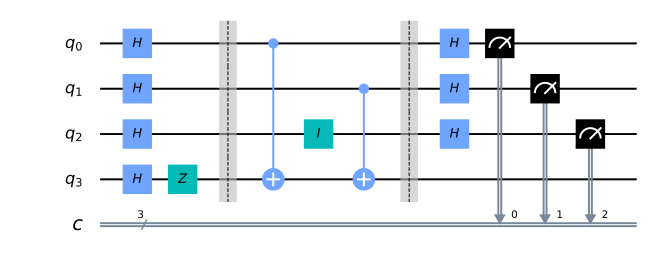

In [4]:
# We need a circuit with n qubits, plus one ancilla qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put ancilla in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw()

### 3a. Experiment with Simulators  <a id='simulation'></a>

We can run the above circuit on the simulator. 

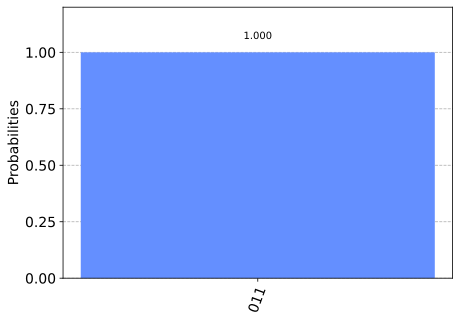

In [5]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(bv_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the hidden string `011`. 

### 3b. Experiment with Real Devices <a id='device'></a>

We can run the circuit on the real device as below.

In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_london


In [7]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(bv_circuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


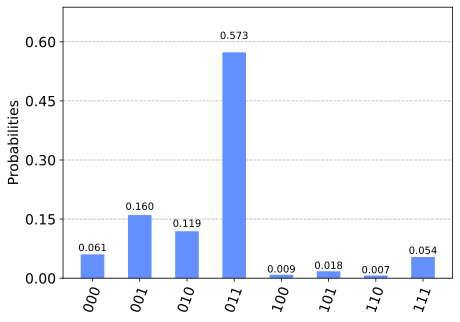

In [8]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, most of the results are `011`. The other results are due to errors in the quantum computation. 

## 4. Exercises <a id='problems'></a>

1. Use the widget below to see the Bernstein-Vazirani algorithm in action on different oracles:

In [9]:
from qiskit_textbook.widgets import bv_widget
bv_widget(3, "011", hide_oracle=False)

HTMLMath(value='$$ |000\\rangle = |000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01*\x00\x00\x01\x08\x08\x06\x00\x00\x00\xe8^\xb9\x1…

2. The above [implementation](#implementation) of Bernstein-Vazirani is for a secret bit string $s = 11$. Modify the implementation for a secret string $s = 1011$. Are the results what you expect? Explain.
3. The above [implementation](#implementation) of Bernstein-Vazirani is for a secret bit string $s = 11$. Modify the implementation for a secret string $s = 11101101$. Are the results what you expect? Explain.

## 5. References <a id='references'></a>
1. Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, [doi:10.1137/S0097539796300921](https://doi.org/10.1137/S0097539796300921).
2. Jiangfeng Du, Mingjun Shi, Jihui Wu, Xianyi Zhou, Yangmei Fan, BangJiao Ye, Rongdian Han (2001) "Implementation of a quantum algorithm to solve the Bernstein-Vazirani parity problem without entanglement on an ensemble quantum computer", Phys. Rev. A 64, 042306, [10.1103/PhysRevA.64.042306](https://doi.org/10.1103/PhysRevA.64.042306), [arXiv:quant-ph/0012114](https://arxiv.org/abs/quant-ph/0012114). 

In [10]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}